# Emission Measure Analysis
Compute emission measure distributions from the time-averaged intensity in each AIA channel using the method of Hannah and Kontar (2012)

In [45]:
import sys

import numpy as np
from scipy.interpolate import splev

from sunpy.map import Map
import astropy.units as u
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch
from astropy.coordinates import SkyCoord
import astropy.modeling
import matplotlib.pyplot as plt
import matplotlib.colors
import dask
import distributed

from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACollection,DistributedAIACube,AIATimelags

sys.path.append('../scripts/')
from dem import HannahKontarModel

%matplotlib inline

Spin up a Dask cluster

In [2]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1,)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39698 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


In [186]:
client.close()

## DEM Setup
Configure IDL code for running DEM model

In [3]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [4]:
temperature_bin_edges = 10.**np.arange(5.3,7.3,0.2) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] 
                           + temperature_bin_edges[:-1])/2.

In [5]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

## Heating Cases

In [6]:
channels = [94,131,171,193,211,335]

In [7]:
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{}/SDO_AIA/{}/map_t{:06d}.fits'

### Cooling

In [39]:
cooling = AIATimelags(*[DistributedAIACube.from_files(
    [read_template.format('cooling/nei',c,i) for i in range(0,1000)]) for c in channels])

This time, we'll average over the whole $10^4$ s

In [9]:
time_average_maps = {c:cooling[c].average() for c in cooling.channels}
time_average_maps = {c:Map(time_average_maps[c].data.compute(),time_average_maps[c].meta) for c in time_average_maps}

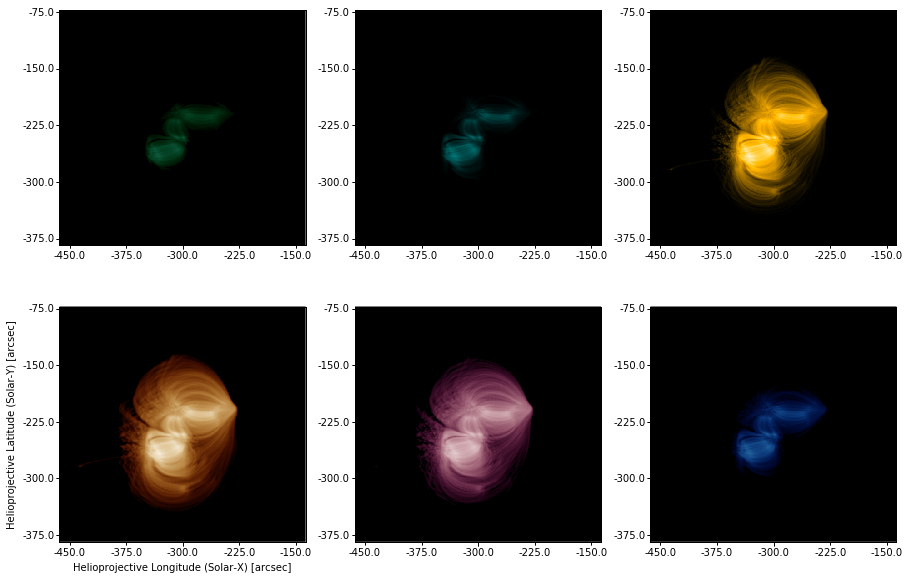

In [10]:
fig = plt.figure(figsize=(15,10))
for i,c in enumerate(cooling.channels):
    ax = fig.add_subplot(2,3,i+1,projection=time_average_maps[c])
    time_average_maps[c].plot(axes=ax,vmin=1,vmax=1e3,title=False,annotate=True if i==3 else False)
    ax.grid(alpha=0)

In [11]:
hk_model = HannahKontarModel([time_average_maps[c] for c in channels],
                             temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl/')

In [12]:
em_cooling = hk_model.fit()

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
-----------------------------------------------

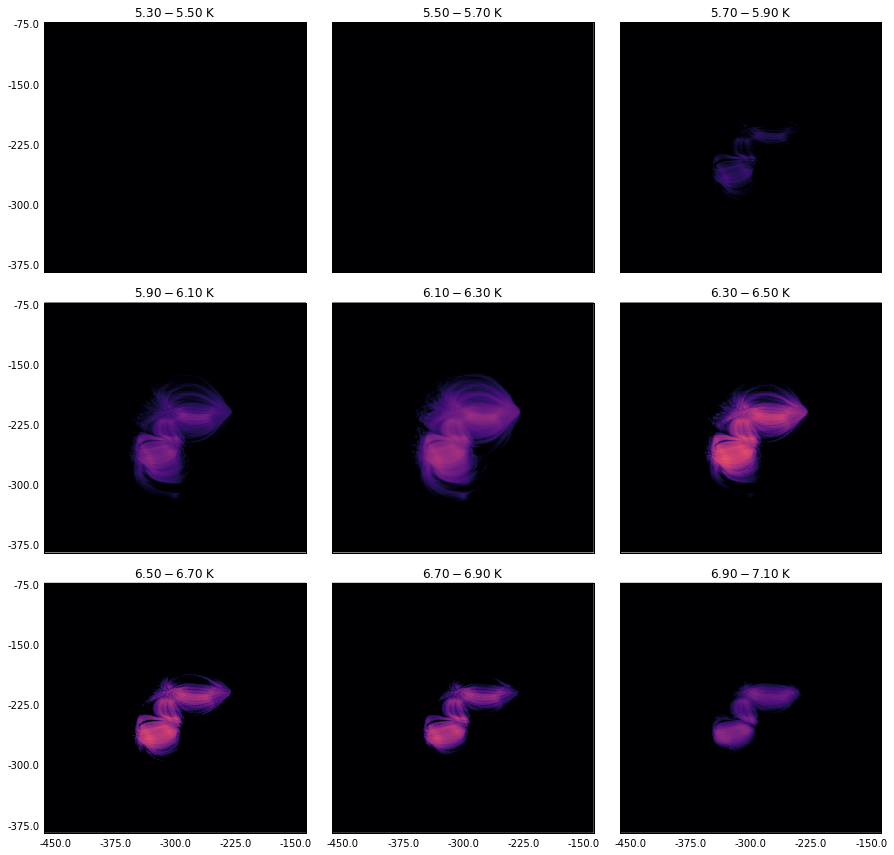

In [141]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(len(em_cooling.maps)):
    tmp = em_cooling[i]
    ax = fig.add_subplot(3,3,i+1,projection=tmp)
    tmp.plot(annotate=False,title=False,axes=ax,
             norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    if i < 6:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(tmp.meta["temp_a"]):.2f}-{np.log10(tmp.meta["temp_b"]):.2f}$ K')

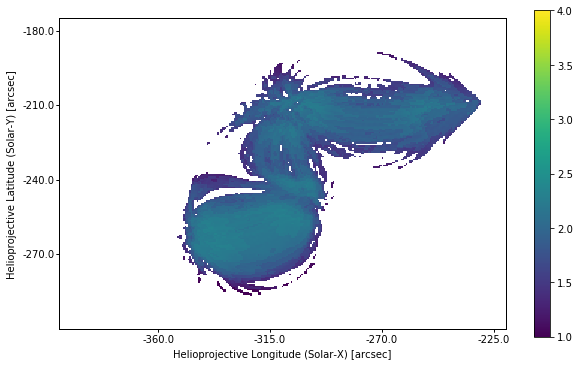

In [37]:
slope_map = em_cooling.make_slope_map(temperature_bounds=[10**(6),10**(6.5)]*u.K,
                                      em_threshold=1e10*u.cm**-5,rsquared_tolerance=0.9)
slope_map_cooling = Map(np.where(slope_map.data == 0, np.nan, slope_map.data), slope_map.meta)
slope_map_cooling = slope_map_cooling.submap(
    SkyCoord(Tx=-400*u.arcsec,Ty=-300*u.arcsec,frame=slope_map_cooling.coordinate_frame),
    SkyCoord(Tx=-220*u.arcsec,Ty=-175*u.arcsec,frame=slope_map_cooling.coordinate_frame))
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection=slope_map_cooling)
im = slope_map_cooling.plot(axes=ax,cmap='viridis',vmin=1,vmax=4,title=False)
ax.grid(alpha=0)
fig.colorbar(im,ax=ax)

### High Frequency

In [131]:
high_freq = AIATimelags(*[DistributedAIACube.from_files([read_template.format('high_frequency/nei',c,i) for i in range(500,2500)]) for c in channels])

In [132]:
time_average_maps = {c:high_freq[c].average() for c in high_freq.channels}
time_average_maps = {c:Map(time_average_maps[c].data.compute(),time_average_maps[c].meta) for c in time_average_maps}

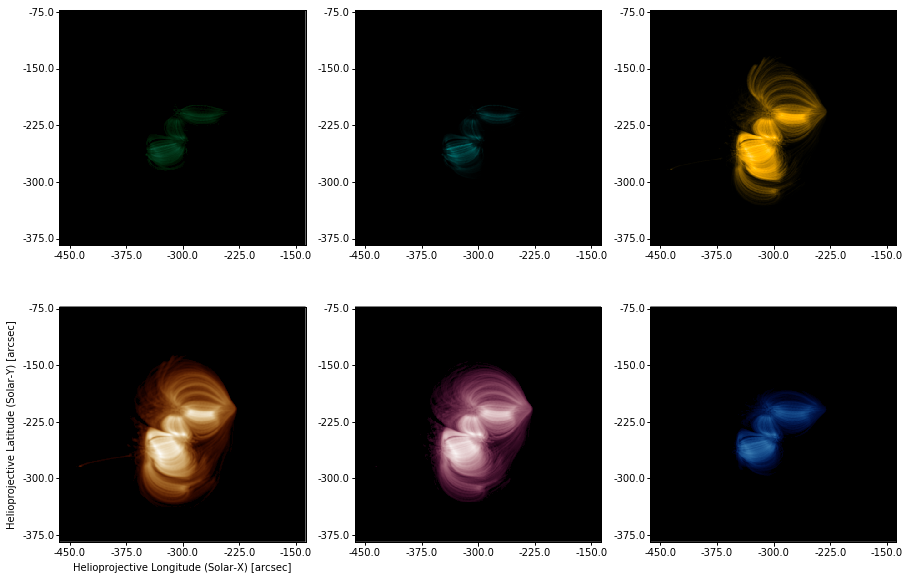

In [133]:
fig = plt.figure(figsize=(15,10))
for i,c in enumerate(high_freq.channels):
    ax = fig.add_subplot(2,3,i+1,projection=time_average_maps[c])
    time_average_maps[c].plot(axes=ax,vmin=1,vmax=1e3,title=False,annotate=True if i==3 else False)
    ax.grid(alpha=0)

First, take the EM and get EM slopes for the average over the whole simulation interval, i.e. $[5000,25000]$ s

In [137]:
hk_model = HannahKontarModel([time_average_maps[c] for c in channels],
                             temperature_bin_edges, responses,
                             dem_path='/storage-home/w/wtb2/codes/demreg/idl/')

In [138]:
em_hf = hk_model.fit()

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
-----------------------------------------------

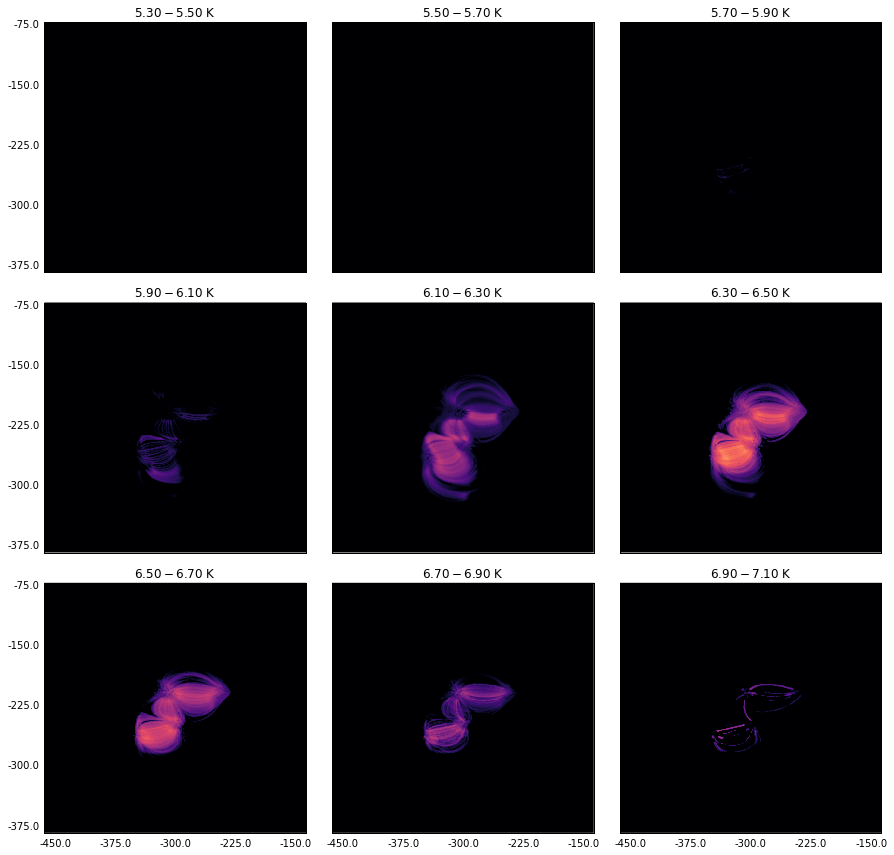

In [139]:
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(len(em_hf.maps)):
    tmp = em_hf[i]
    ax = fig.add_subplot(3,3,i+1,projection=tmp)
    tmp.plot(annotate=False,title=False,axes=ax,
             norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29))
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lat.set_ticks_visible(False)
    if i%3 != 0:
        lat.set_ticklabel_visible(False)
    if i < 6:
        lon.set_ticklabel_visible(False)
    ax.set_title(f'${np.log10(tmp.meta["temp_a"]):.2f}-{np.log10(tmp.meta["temp_b"]):.2f}$ K')

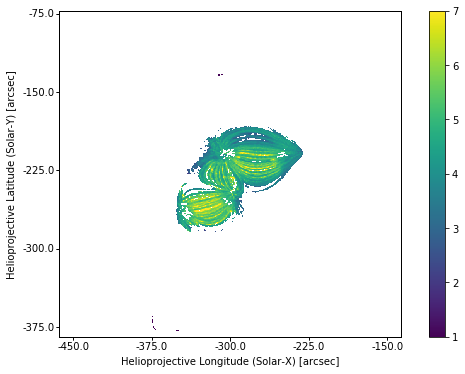

In [142]:
slope_map = em_hf.make_slope_map(temperature_bounds=[10**(6),10**(6.5)]*u.K,
                                 em_threshold=1e10*u.cm**-5,rsquared_tolerance=0.9)
slope_map_hf = Map(np.where(slope_map.data == 0, np.nan, slope_map.data), slope_map.meta)
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection=slope_map_hf)
im = slope_map_hf.plot(axes=ax,cmap='viridis',vmin=1,vmax=7,title=False)
ax.grid(alpha=0)
fig.colorbar(im,ax=ax)

Next, split the interval in half (i.e. $[5000,15000]$ s and $[15000,25000]$ s) and compute the slopes for each. Then, average and compare to the first answer.

In [143]:
hk_model = HannahKontarModel(
    [Map(c.rechunk(c.shape[:1]+(c.shape[1]//10, c.shape[2]//10))[:1000,:,:].mean(
        axis=0,dtype=np.float64).compute(), c.maps[0].meta.copy()) for c in high_freq],
    temperature_bin_edges, responses, dem_path='/storage-home/w/wtb2/codes/demreg/idl/')

In [144]:
em_hf = hk_model.fit()

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
-----------------------------------------------

In [151]:
slope_map = em_hf.make_slope_map(temperature_bounds=[10**(6),10**(6.5)]*u.K,
                                 em_threshold=1e10*u.cm**-5,rsquared_tolerance=0.9)
slope_map_hf_half1 = Map(np.where(slope_map.data == 0, np.nan, slope_map.data), slope_map.meta)

In [152]:
hk_model = HannahKontarModel(
    [Map(c.rechunk(c.shape[:1]+(c.shape[1]//10, c.shape[2]//10))[1000:,:,:].mean(
        axis=0,dtype=np.float64).compute(), c.maps[0].meta.copy()) for c in high_freq],
    temperature_bin_edges, responses, dem_path='/storage-home/w/wtb2/codes/demreg/idl/')

In [153]:
em_hf = hk_model.fit()

IDL 8.7.0 (linux x86_64 m64).
(c) 2018, Harris Geospatial Solutions, Inc.

Licensed for use by: Rice University (Main) via idl.lic.rice.edu:7070
License: 401801:****-****-****-AE5F
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
% SSW_PATH: Number of paths changed from 95 to 111
% Compiled module: HISSW_PROCEDURE.
% Compiled module: AIA_BP_READ_ERROR_TABLE.
% Compiled module: RD_TFILE.
% Compiled module: AIA_BP_ESTIMATE_ERROR.
% Compiled module: DN2DEM_POS_NB.
% Compiled module: GET_EDGES.
% Compiled module: EDGE_PRODUCTS.
% Compiled module: INTERPOL.
% Compiled module: DEMMAP_POS.
% Compiled module: DEM_INV_GSVDCSQ.
% Compiled module: DEM_INV_REG_PARAMETER_MAP.

SSW  setup will include: <gen sdo/aia>

Type <sswidl> to start SSW IDL
-----------------------------------------------

In [154]:
slope_map = em_hf.make_slope_map(temperature_bounds=[10**(6),10**(6.5)]*u.K,
                                 em_threshold=1e10*u.cm**-5,rsquared_tolerance=0.9)
slope_map_hf_half2 = Map(np.where(slope_map.data == 0, np.nan, slope_map.data), slope_map.meta)

In [156]:
slope_map_hf_avg = Map((slope_map_hf_half1.data + slope_map_hf_half2.data)/2, slope_map.meta)

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


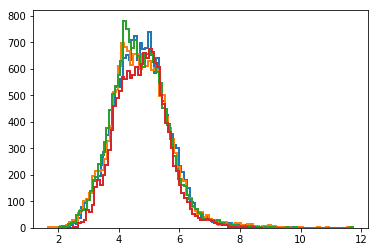

In [157]:
sdist = slope_map_hf.data.flatten()
plt.hist(sdist[sdist > 0],bins='fd',lw=2,histtype='step');
sdist = slope_map_hf_half1.data.flatten()
plt.hist(sdist[sdist>0],bins='fd',lw=2,histtype='step');
sdist = slope_map_hf_half2.data.flatten()
plt.hist(sdist[sdist>0],bins='fd',lw=2,histtype='step');
sdist = slope_map_hf_avg.data.flatten()
plt.hist(sdist[sdist>0],bins='fd',lw=2,histtype='step');

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater


Text(8,600,'$A=717.617$\n$\\mu=4.710$\n$\\sigma=0.883$')

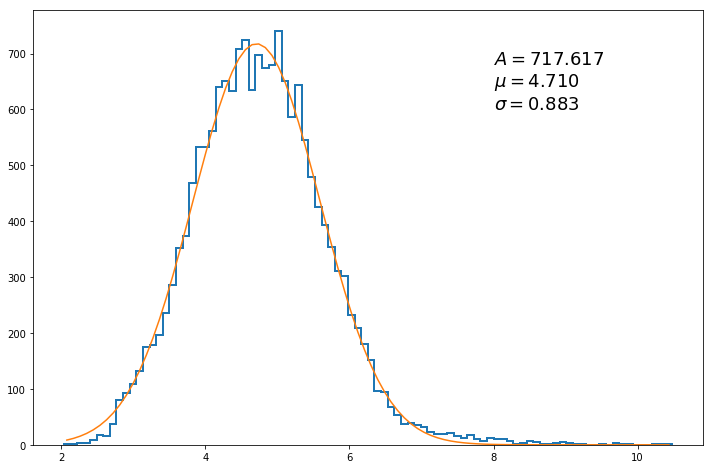

In [183]:
# High Frequency
sdist = slope_map_hf.data.flatten()
h,bins = np.histogram(sdist[sdist > 0],bins='fd',);
b = (bins[1:] + bins[:-1])/2
gm = astropy.modeling.models.Gaussian1D(amplitude=1.1,mean=0,stddev=1)
hfit = astropy.modeling.fitting.LevMarLSQFitter()(gm,b,h)
plt.figure(figsize=(12,8))
plt.hist(sdist[sdist > 0],bins=bins,lw=2,histtype='step');
plt.plot(b,hfit(b))
plt.text(8,600,'$A={:.3f}$\n$\mu={:.3f}$\n$\sigma={:.3f}$'.format(*hfit.parameters),fontsize=18)

## Sandbox

In [126]:
cc_1d = cooling.correlation_1d(335,131,(-300*u.arcsec,-300*u.arcsec),(-290*u.arcsec,-290*u.arcsec)).compute()

In [127]:
#params = {'amplitude':1,'mean':0,'stddev':2}
params = {'amplitude':1,'x_0':0,'fwhm':1}
gmodel = astropy.modeling.models.Lorentz1D(**params)

In [128]:
fitter = astropy.modeling.fitting.LevMarLSQFitter()

In [129]:
gfit = fitter(gmodel,cooling.timelags,cc_1d)

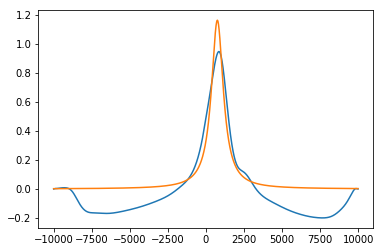

In [130]:
plt.plot(cooling.timelags,cc_1d)
plt.plot(cooling.timelags,gfit(cooling.timelags))
#plt.xlim(-3600,3600)